# Chirp Function

We will deal with [linear frequency modulated (LFM)](https://en.wikipedia.org/wiki/Chirp) or "chirp" radars and ionosondes. These systems transmit rising tones that linearly increase in frequency over time. They can be expressed as

$$ y(t) = \cos(\omega(t) t)$$

or

$$ y(t) = e^{j \omega(t) t}$$

where

$$\omega(t) = mt + b$$

and $m$ and $b$ are constants.

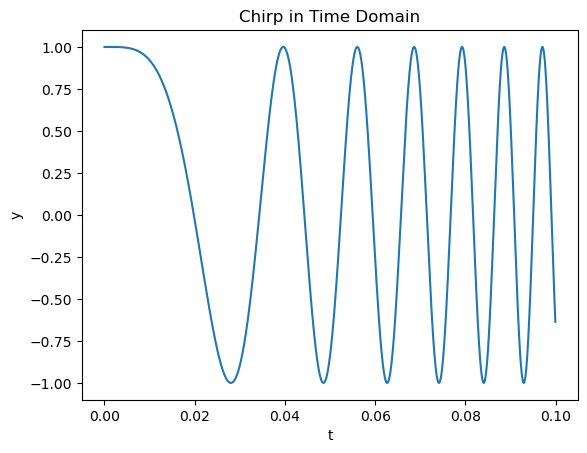

In [1]:
import numpy as np
import matplotlib.pyplot as plt

fs = 20e3  # sampling rate
N = 1e5    # number of samples

m = 1/5 # chirp slope
b = 0.0 # chirp initial frequency

t = np.arange(N) / float(fs)
w = m * t + b
y = np.cos(w * fs * t)

idxs = t < 0.1  # restrict plotting to close to zero

plt.plot(t[idxs], y[idxs])
plt.xlabel('t')
plt.ylabel('y')
plt.title('Chirp in Time Domain')
plt.show()

## Spectrum of Chirp

If we take the FFT of $y(t)$, what do we expect?

*(Computing this might take a minute)*

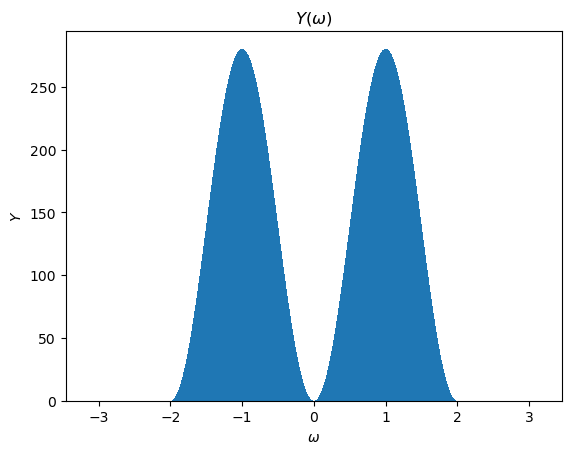

In [2]:
freq = np.fft.fftfreq(t.shape[-1])
omega = 2 * np.pi * freq
win = np.hanning(len(y))
Y = np.fft.fft(win * y)

plt.bar(omega, np.abs(Y), width=2 * np.pi / N)
plt.xlabel('$\omega$')
plt.ylabel('$Y$')
plt.title('$Y(\omega)$')

plt.show()

There isn't a clear peak, because the signal has frequency components ranging from $\omega(0) = 0$ to $\omega(10) = 1$.

**Question:** How can we visualize the rising tone using our knowledge of the FFT?

**Answer:** By chopping up the time-domain signal into chunks, taking the FFT of each chunk, and seeing how the FFT changes from chunk to chunk. This is called the [short-time Fourier transform (STFT)](https://en.wikipedia.org/wiki/Short-time_Fourier_transform).

## Short-Time Fourier Transform

Chopping up the $N$ samples of $y$ into overlapping chunks of length $N/100$, we get

In [3]:
M = int(N / 1000)
chunks_y = []
chunks_t = []

for i in range(M):
    chunk_y = y[i * M : (i + 1) * M]
    chunk_t = t[i * M : (i + 1) * M]
    
    chunks_y.append(chunk_y)
    chunks_t.append(chunk_t)

Visualizing the FFT of successive chunks, we see

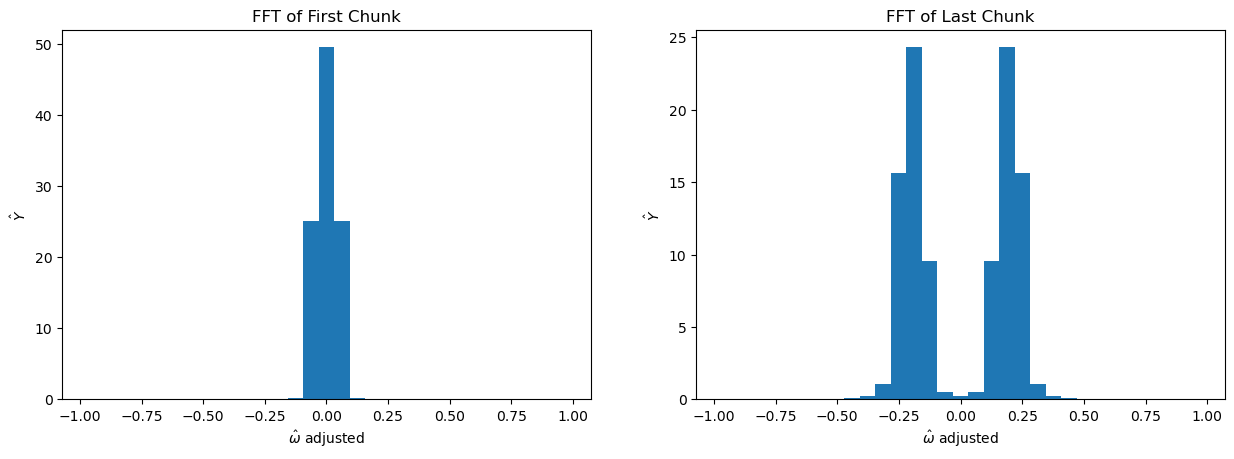

In [4]:
plt.figure().set_figwidth(15)

y_first = chunks_y[0]
y_last = chunks_y[-1]

freq = np.fft.fftfreq(y_first.shape[-1])
omega = 2 * np.pi * freq
win = np.hanning(len(y_first))
Spec_first = np.fft.fft(win * y_first)
Spec_last = np.fft.fft(win * y_last)

idxs = np.abs(omega) < 1 # restrict plotting to low frequencies

plt.subplot(1, 2, 1)
plt.bar(omega[idxs], np.abs(Spec_first[idxs]), width=2 * np.pi / len(Spec_first))
plt.xlabel('$\hat{\omega}$ adjusted')
plt.ylabel('$\hat{Y}$')
plt.title('FFT of First Chunk')

plt.subplot(1, 2, 2)
plt.bar(omega[idxs], np.abs(Spec_last[idxs]), width=2 * np.pi / len(Spec_last))
plt.xlabel('$\hat{\omega}$ adjusted')
plt.ylabel('$\hat{Y}$')
plt.title('FFT of Last Chunk')

plt.show()

As we can see, the dominant frequency changed from $\omega(0) = 0$ to $\omega(10) = 1$ in the original spectrum, then was squeezed to appear even smaller by the downsampling of the STFT.

## Spectrogram

To visualize this signal's frequency response over time, we can aggregate the FFTs of all the chunks into a 3D plot. Here, the $x$ axis represents the chunk index, the $y$ axis is the FFT frequency bin index, and the $z$ axis represents the magnitude of the FFT value at the given frequency within the given chunk. Additionally, we can scale so that the $x$ axis is in seconds and the $y$ axis is in Hz. This type of plot is called a [spectrogram](https://en.wikipedia.org/wiki/Spectrogram), and is implemented by `scipy`. For plotting convenience, we'll plot in 2D and represent the $z$ axis using a colormap.

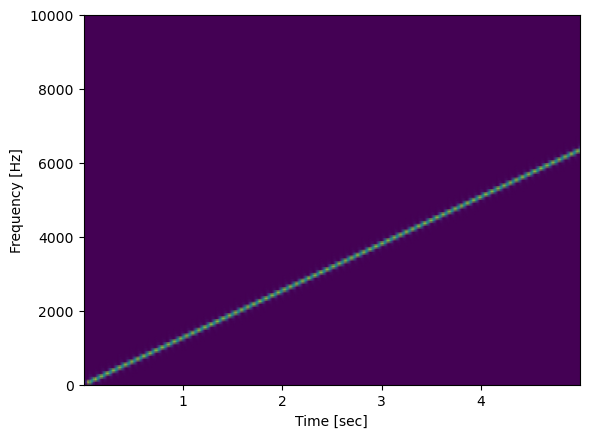

In [5]:
from scipy import signal

f, t, Sxx = signal.spectrogram(y, fs)
plt.pcolormesh(t, f, Sxx, shading='gouraud')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()